In [88]:
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib
import tensorflow as tf
from tensorflow import keras
import sklearn as sk

# keras functions to use
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import regularizers
from sklearn.utils import class_weight

import warnings  
warnings.filterwarnings('ignore')

In [89]:
data = pd.read_csv('H1_breakout.csv') # read csv file of trades
data.head()

,pair,frame,rg,h,l,c1,c2,c3,supp,o_s,p_s,obv1,obv2,obv3,rsi1,rsi2,rsi3,natr,cyc,result
0,CAD_JPY,H1,33,84.772,84.514,84.596,84.726,84.828,84.596,0.002010,0.002444,0.314103,0.493719,0.603425,37.034184,43.919029,50.799587,0.145238,1.041987,0.0
1,CAD_JPY,H1,34,84.772,84.514,84.596,84.726,84.828,84.596,0.003135,0.003158,0.314103,0.493719,0.603425,36.231891,43.112937,50.036368,0.145238,1.041987,0.0
2,CAD_JPY,H1,35,84.772,84.514,84.596,84.726,84.828,84.596,0.003636,0.003284,0.314103,0.493719,0.603425,34.713578,41.272618,47.861283,0.145238,1.041987,0.0
3,CAD_JPY,H1,36,84.772,84.514,84.596,84.726,84.828,84.596,0.004518,0.003637,0.314103,0.493719,0.603425,35.229599,41.946009,48.712112,0.145238,1.041987,0.0
4,CAD_JPY,H1,37,84.772,84.514,84.596,84.726,84.828,84.596,0.004738,0.003481,0.314103,0.493719,0.603425,33.855445,40.286574,46.757772,0.145238,1.041987,0.0


In [90]:
print("len of result:", len(data['result']))

len of result: 6167


In [91]:
# drop string columns
data.drop(data.columns[[0, 1]], axis=1, inplace=True)
    
# convert to float
for col in data:
    data[col] = pd.to_numeric(data[col])
    
# delete rows with nans
data = data.dropna()

In [92]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6131 entries, 0 to 6144
Data columns (total 18 columns):
rg        6131 non-null int64
h         6131 non-null float64
l         6131 non-null float64
c1        6131 non-null float64
c2        6131 non-null float64
c3        6131 non-null float64
supp      6131 non-null float64
o_s       6131 non-null float64
p_s       6131 non-null float64
obv1      6131 non-null float64
obv2      6131 non-null float64
obv3      6131 non-null float64
rsi1      6131 non-null float64
rsi2      6131 non-null float64
rsi3      6131 non-null float64
natr      6131 non-null float64
cyc       6131 non-null float64
result    6131 non-null float64
dtypes: float64(17), int64(1)
memory usage: 910.1 KB


In [93]:
pos = (list(np.where(data['result'] == 1.0)[0]))
neg = (list(np.where(data['result'] == 0.0)[0]))

print("breakouts:", len(pos), " | ", "false breakouts:", len(neg))

breakouts: 802  |  false breakouts: 5329


In [94]:
index = range(len(data['result']))
data['index'] = index

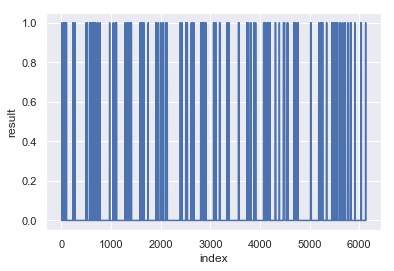

In [95]:
# do some visualization with result column
# we result to be evenly distributed
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

ax = sns.lineplot(x="index", 
                  y="result",
                  data=data)
plt.show()

In [96]:
X = data[['rg', 'h', 'l', 'c1', 'c2', 'c3', 'supp', 'o_s', 'p_s', 'obv1', 'obv2', 'obv3', 'rsi1', 'rsi2', 'rsi3', 'natr', 'cyc']]
y = data['result']

sc = MinMaxScaler()
X = sc.fit_transform(X)

# save sc so we can use it for predictions
scaler_filename = "H1_BR_scaler.save"
joblib.dump(sc, scaler_filename)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

neg = pos = 0
for val in y_test:
    if val < 0.5:
        neg += 1
    else:
        pos += 1
print("pos:", pos, " | neg:", neg)

pos: 156  | neg: 1071


In [97]:
# build a logistic regression model
# Posted accuracy of .75 - .83 
# accuracy not meaningful because of unbalanced nature of dataset

from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
predictions = logisticRegr.predict(X_test)
score = logisticRegr.score(X_test, y_test)
print(score)

0.8728606356968215


In [98]:
# Build the deep neural net: Posted Accuracy of .9 on train, .85 on test

# Number of neurons in the first layer = number of columns in dataset
# Activation function = ReLU
# 5 Hidden layers for a total of 6 layers in the network
# Last layer activation function = Sigmoid

class_weights = class_weight.compute_class_weight('balanced', 
                                                  np.unique(y_train), 
                                                  y_train)

model = Sequential()

# input layer
model.add(Dense(100, activation='relu', input_dim = 17))
          
# second layer
model.add(Dense(60, activation='relu'))
          
# third layer
model.add(Dense(60, activation='relu'))
          
# fourth layer
model.add(Dense(60, activation='relu'))

# fith layer
model.add(Dense(60, activation='relu'))
          
# output layer
model.add(Dense(1, activation='sigmoid'))

# compile the model using rmsprop opt and mse loss
model.compile(optimizer = 'adam',     
              loss = 'mse',
              metrics = ['accuracy'])

# Train the model, iterating on the data in batches of 32 samples
history = model.fit(X_train, y_train, 
                    validation_split = 0.33, 
                    epochs = 75,
                    #class_weight = class_weights,
                    batch_size = 25)

# Evaluate the model's performance
train_loss, train_acc = model.evaluate(X_train, y_train)
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Training set accuracy:', train_acc)
print('Test set accuracy:', test_acc)

Train on 3285 samples, validate on 1619 samples
Epoch 1/75
3285/3285 [==============================] - 1s 433us/step - loss: 0.1188 - acc: 0.8734 - val_loss: 0.1209 - val_acc: 0.8579
Epoch 2/75
3285/3285 [==============================] - 0s 132us/step - loss: 0.1092 - acc: 0.8734 - val_loss: 0.1163 - val_acc: 0.8579
Epoch 3/75
3285/3285 [==============================] - 0s 131us/step - loss: 0.1068 - acc: 0.8734 - val_loss: 0.1135 - val_acc: 0.8579
Epoch 4/75
3285/3285 [==============================] - 0s 124us/step - loss: 0.1021 - acc: 0.8734 - val_loss: 0.1088 - val_acc: 0.8647
Epoch 5/75
3285/3285 [==============================] - 0s 129us/step - loss: 0.1013 - acc: 0.8776 - val_loss: 0.1110 - val_acc: 0.8691
Epoch 6/75
3285/3285 [==============================] - 0s 125us/step - loss: 0.0991 - acc: 0.8843 - val_loss: 0.1093 - val_acc: 0.8715
Epoch 7/75
3285/3285 [==============================] - 0s 122us/step - loss: 0.0962 - acc: 0.8843 - val_loss: 0.1032 - val_acc: 0.8771


3285/3285 [==============================] - 0s 118us/step - loss: 0.0333 - acc: 0.9595 - val_loss: 0.0579 - val_acc: 0.9321
Epoch 60/75
3285/3285 [==============================] - 0s 121us/step - loss: 0.0395 - acc: 0.9507 - val_loss: 0.0653 - val_acc: 0.9209
Epoch 61/75
3285/3285 [==============================] - 0s 121us/step - loss: 0.0408 - acc: 0.9476 - val_loss: 0.0592 - val_acc: 0.9271
Epoch 62/75
3285/3285 [==============================] - 0s 122us/step - loss: 0.0303 - acc: 0.9623 - val_loss: 0.0562 - val_acc: 0.9327
Epoch 63/75
3285/3285 [==============================] - 0s 123us/step - loss: 0.0315 - acc: 0.9613 - val_loss: 0.0606 - val_acc: 0.9271
Epoch 64/75
3285/3285 [==============================] - 0s 122us/step - loss: 0.0375 - acc: 0.9504 - val_loss: 0.0521 - val_acc: 0.9382
Epoch 65/75
3285/3285 [==============================] - 0s 123us/step - loss: 0.0308 - acc: 0.9613 - val_loss: 0.0529 - val_acc: 0.9370
Epoch 66/75
3285/3285 [==============================

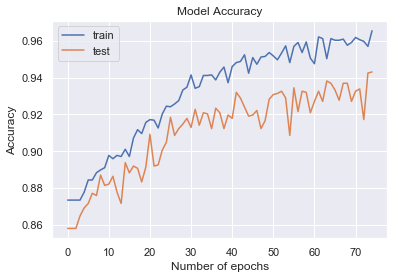

In [99]:
# The history of our accuracy during training.
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

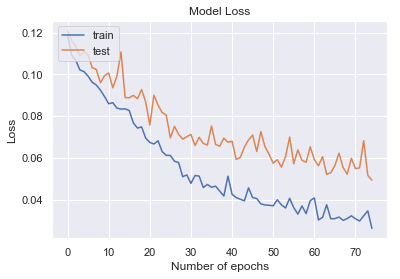

In [100]:
# The history of our cross-entropy loss during training.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [101]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 100)               1800      
_________________________________________________________________
dense_26 (Dense)             (None, 60)                6060      
_________________________________________________________________
dense_27 (Dense)             (None, 60)                3660      
_________________________________________________________________
dense_28 (Dense)             (None, 60)                3660      
_________________________________________________________________
dense_29 (Dense)             (None, 60)                3660      
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 61        
Total params: 18,901
Trainable params: 18,901
Non-trainable params: 0
_________________________________________________________________


In [102]:
predictions = model.predict(X_test)
neg = pos = 0
for pred in predictions:
    if pred < 0.5:
        neg += 1
    else:
        pos += 1
print("pos:", pos, " | neg:", neg)

pos: 124  | neg: 1103


In [103]:
# save the model for later use

from keras.models import load_model
model.save('H1_DNN_Breakout')  # creates a HDF5 file
del model  # deletes the existing model

# load model to make sure that it was correctly saved
model = load_model('H1_DNN_Breakout')

test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test set accuracy:', test_acc)

1227/1227 [==============================] - 0s 173us/step
Test set accuracy: 0.9494702528916245
